In [155]:
from sql_functions import get_dataframe
import pandas as pd
import capstone_functions as cf
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from scipy import interpolate
from sklearn import linear_model
import seaborn as sns

pd.options.mode.chained_assignment = None  # default='warn'

# Variables

In [156]:
# How many mechanics are in the top mechanics
top_XX_mechanic = 25

#schema and table names, we are using in this notebook
schema = 'bgg_data'
main = 'ml_boardgame_stats'
subdomain = 'subdomain'
unique_subdomain = 'unique_subdomain'
kickstarter = 'kickstarter_unique_campaigns'
slug = 'unique_slug_bgg_id'
mechanic = 'mechanics'
unique_mechanics = 'unique_mechanics'
honor = 'honor_clean'

## Create Dataframes for Kickstarter and Mechanic and build df for the top XX mechanics

In [157]:

df_ks = get_dataframe(f"SELECT * FROM {schema}.{kickstarter}")
df_slug = get_dataframe(f"SELECT * FROM {schema}.{slug}")
df_mech = get_dataframe(f"SELECT * FROM {schema}.{mechanic}")
df_u_mech = get_dataframe(f"SELECT * FROM {schema}.{unique_mechanics}")

#df_marketplace = cf.avg_price_from_marketplace()
#df_honor = get_dataframe(f"SELECT * FROM {schema}.{honor}")

Merge kickstarter table with bgg_ids and rename column bgg_id to id

In [158]:
df_ks = pd.merge(df_slug,df_ks,on='slug')
df_ks.rename({'bgg_id':'id'},axis=1,inplace=True)

create dataframe with all mechanics and merge it with the kickstarter dataframe

In [159]:
df_mech = pd.merge(df_mech,df_u_mech,on='mechanic_id')
df_mech = pd.merge(df_ks,df_mech,on='id')

create a list with the top XX mechanics

In [160]:
top_mechanics_list = list(df_mech.groupby(['mechanic']).count().sort_values(ascending=False,axis=0,by='id').reset_index()["mechanic"].head(top_XX_mechanic))

reduce the dataframe such that IDs are unique

In [161]:
df_mech["is_in_top_XX_mechanics"] = df_mech["mechanic"].isin(top_mechanics_list)
df_mech = df_mech[['id','is_in_top_XX_mechanics']]
df_mech = df_mech.groupby('id').sum().reset_index()

Because there are multiple mechanics for one ID, it is possible that for the same ID there are some mechanics in the top and others are not.
- create new column with True/False if ID is in top XX categories (XX will be set in the top code field: "Variables" -> "top_XX_mechanic")

In [162]:
df_mech[f"top_{top_XX_mechanic}_mechanic"] = df_mech.is_in_top_XX_mechanics > 0

In [163]:
df_mech = df_mech[['id',f"top_{top_XX_mechanic}_mechanic"]]

## Create Dataframes for main and subdomain

In [164]:
df_main = get_dataframe(f"SELECT * FROM {schema}.{main}")
df_sub = get_dataframe(f"SELECT * FROM {schema}.{subdomain}")
df_u_sub = get_dataframe(f"SELECT * FROM {schema}.{unique_subdomain}")

- merge Kickstarter with subdomains => 1021 non-null

In [165]:
df_sub = pd.merge(df_sub,df_u_sub,on="subdomain_id")
df_ks_sub = pd.merge(df_ks,df_sub,on='id')

- merge Kickstarter_subdomains with main => ~330 entries

In [166]:
df_ks_sub_main = pd.merge(df_ks_sub,df_main,on='id')

- Build new columns with goal in USD

In [167]:
df_ks_sub_main["usd_goal"] = df_ks_sub_main['goal']*(df_ks_sub_main.pledged/df_ks_sub_main.usd_pledged)

merge with mechanics dataframe => 326 non-null entries

In [168]:
df_ks_sub_main_mech = pd.merge(df_ks_sub_main,df_mech,on='id')

In [169]:
#df_ks_sub_main_mech.columns

## Machine Learning
- Extract only necessary columns for our ML and drop all null

In [170]:
df_ML = df_ks_sub_main_mech[['country','usd_pledged','subdomain_name','min_players','max_players','min_playtime','max_playtime','min_age','averageweight','usd_goal',f"top_{top_XX_mechanic}_mechanic"]]
#df_ML.dropna(inplace=True);

In [171]:
df_ML[f"top_{top_XX_mechanic}_mechanic"] = df_ML[f"top_{top_XX_mechanic}_mechanic"].astype(int)

In [172]:
df_ML["min_playtime"].fillna(df_ML["max_playtime"].median(),inplace=True);
df_ML["max_playtime"].fillna(df_ML["max_playtime"].median(),inplace=True);


In [173]:
df_ML = df_ML[(np.abs(stats.zscore(df_ML['min_playtime'])) < 2.5)]
df_ML = df_ML[(np.abs(stats.zscore(df_ML['max_playtime'])) < 3)]

In [174]:
#df_ML.describe()

## Build dummies for subdomain and countries

In [175]:
subdomain_dummy = pd.get_dummies(df_ML.subdomain_name.apply(pd.Series).stack(), drop_first=True).groupby(level=0).sum()
subdomain_dummy.columns = subdomain_dummy.columns.str.strip()

In [176]:
country_dummy = pd.get_dummies(df_ML.country.apply(pd.Series).stack(), drop_first=True).groupby(level=0).sum()
country_dummy.columns = country_dummy.columns.str.strip()

In [177]:
df = pd.concat([df_ML,subdomain_dummy], axis=1)
df = df.drop(["subdomain_name"], axis=1)
#df.columns

In [178]:
df = pd.concat([df,country_dummy], axis=1)
df = df.drop(["country"], axis=1)
df.columns

Index(['usd_pledged', 'min_players', 'max_players', 'min_playtime',
       'max_playtime', 'min_age', 'averageweight', 'usd_goal',
       'top_25_mechanic', 'Children's', 'Customizable', 'Family', 'Party',
       'Strategy', 'Thematic', 'Wargames', 'AU', 'BE', 'CA', 'CH', 'DE', 'ES',
       'FR', 'GB', 'HK', 'IT', 'NL', 'NO', 'SG', 'US'],
      dtype='object')

In [179]:
X = df[['DE', 'GB', 'US',
        "Children's", "Customizable", "Family", "Party", "Strategy", "Thematic", "Wargames", 
        "min_players", "min_playtime", "min_age", "averageweight", 'usd_goal',f"top_{top_XX_mechanic}_mechanic"]]

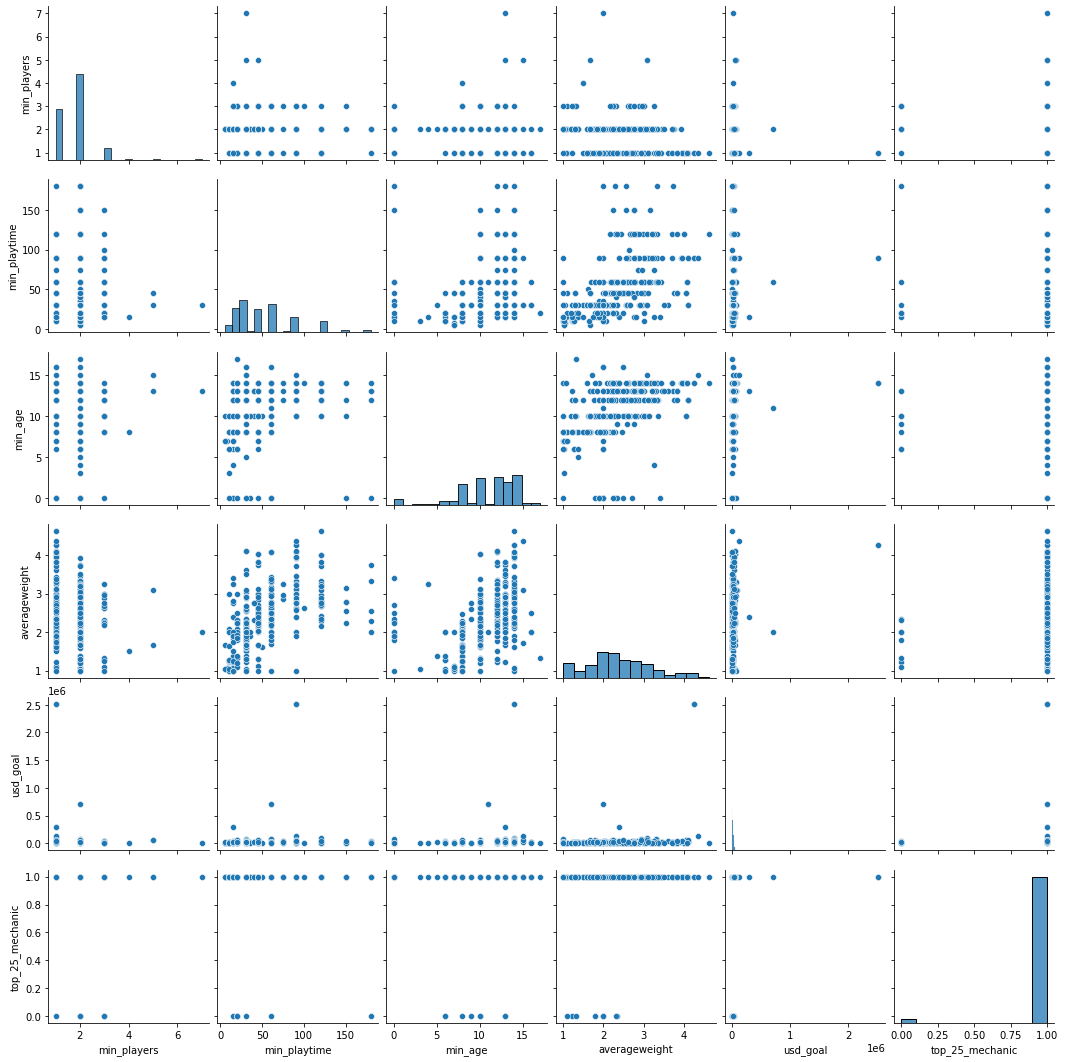

In [190]:
X = df[["min_players", "min_playtime", "min_age", "averageweight", 'usd_goal',f"top_{top_XX_mechanic}_mechanic"]]
sns.pairplot(X)

In [181]:
y = df.usd_pledged

In [182]:
X = sm.add_constant(X)

#### Investigate the whole dataframe with all columns of interest

In [183]:
# create an OLS model
our_model = sm.OLS(y, X)

# use the data to calculate the intercept and slope
model_results = our_model.fit()

# return the output of the model
model_results.summary() # summary contains eg. 'const' (intercept) and 'slope' of the regression equation.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            usd_pledged   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                     4.766
Date:                Wed, 13 Jul 2022   Prob (F-statistic):           1.21e-08
Time:                        15:46:58   Log-Likelihood:                -4400.2
No. Observations:                 318   AIC:                             8834.
Df Residuals:                     301   BIC:                             8898.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -1.126e+05   1.28e+05     -0.882      0.378   -3.64e+05    1.39e+05
DE               3.602e+05   1.35e+05      2.661      0.008    9.38e+04    6.27e+05
GB              -4716.6202    5.6e+04     -0.084      0.933   -1.15e+05    1.06e+05
US               2.146e+04   3.97e+04      0.541      0.589   -5.67e+04    9.96e+04
Children's      -6.335e+04   1.12e+05     -0.567      0.571   -2.83e+05    1.57e+05
Customizable     -1.02e+05    2.6e+05     -0.392      0.695   -6.14e+05     4.1e+05
Family           1.205e+04   5.94e+04      0.203      0.839   -1.05e+05    1.29e+05
Party            4.457e+05   8.39e+04      5.313      0.000    2.81e+05    6.11e+05
Strategy        -9090.8671   6.21e+04     -0.146      0.884   -1.31e+05    1.13e+05
Thematic         5.679e+04   6.52e+04      0.871      0.384   -7.15e+04    1.85e+05
Wargames        -6.337e+04   6.29e+04     -1.007      0.315   -1.87e+05    6.05e+04
min_players     -3.077e+04   2.23e+04     -1.377      0.170   -7.47e+04    1.32e+04
min_playtime     -760.0124    514.228     -1.478      0.140   -1771.950     251.925
min_age         -3746.0866   4959.255     -0.755      0.451   -1.35e+04    6013.115
averageweight    9.933e+04   2.67e+04      3.720      0.000    4.68e+04    1.52e+05
usd_goal            0.1634      0.074      2.211      0.028       0.018       0.309
top_25_mechanic  1.141e+05   8.82e+04      1.294      0.197   -5.95e+04    2.88e+05
==============================================================================
Omnibus:                      273.025   Durbin-Watson:                   1.518
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5845.525
Skew:                           3.474   Prob(JB):                         0.00
Kurtosis:                      22.822   Cond. No.                     3.77e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.77e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### ...and pick columns accordingly

In [199]:
#X = df[['averageweight','usd_goal','min_playtime','Party','DE']]
X = df[['averageweight','min_playtime','Party','DE']]
X = sm.add_constant(X)
X.describe()

,const,averageweight,min_playtime,Party,DE
count,318.0,318.000000,318.000000,318.000000,318.000000
mean,1.0,2.376470,52.399371,0.050314,0.012579
std,0.0,0.779356,36.334768,0.218938,0.111622
min,1.0,1.000000,5.000000,0.000000,0.000000
25%,1.0,1.900800,30.000000,0.000000,0.000000
50%,1.0,2.303850,45.000000,0.000000,0.000000
75%,1.0,2.864750,60.000000,0.000000,0.000000
max,1.0,4.616300,180.000000,1.000000,1.000000


In [200]:
# create an OLS model
our_model = sm.OLS(y, X)
#our_model = sm.MANOVA(y, X)

# use the data to calculate the intercept and slope
model_results = our_model.fit()

# return the output of the model
model_results.summary() # summary contains eg. 'const' (intercept) and 'slope' of the regression equation.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            usd_pledged   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     15.01
Date:                Wed, 13 Jul 2022   Prob (F-statistic):           3.10e-11
Time:                        16:26:25   Log-Likelihood:                -4408.2
No. Observations:                 318   AIC:                             8826.
Df Residuals:                     313   BIC:                             8845.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -9.225e+04   4.87e+04     -1.894      0.059   -1.88e+05    3603.816
averageweight  1.134e+05   2.19e+04      5.168      0.000    7.02e+04    1.57e+05
min_playtime  -1233.5413    461.483     -2.673      0.008   -2141.542    -325.541
Party          4.083e+05   6.83e+04      5.979      0.000    2.74e+05    5.43e+05
DE             3.114e+05   1.29e+05      2.414      0.016    5.76e+04    5.65e+05
==============================================================================
Omnibus:                      271.053   Durbin-Watson:                   1.522
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5714.510
Skew:                           3.442   Prob(JB):                         0.00
Kurtosis:                      22.594   Cond. No.                         574.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
regr = linear_model.LinearRegression()
regr.fit(X, y)

LinearRegression()

In [203]:
# ['const', 'averageweight','usd_goal','min_playtime','Party', 'DE']
predicted_pledged_amount = regr.predict([[1, 4, 50000, 20, 0, 0]])
predicted_pledged_amount

/opt/homebrew/Caskroom/miniconda/base/envs/nf_sql/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


<function ndarray.std>